In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt

We load the image

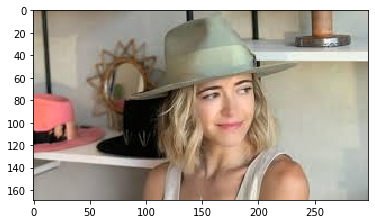

In [2]:
img = cv2.imread('image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

Convert the image to a grey scale image

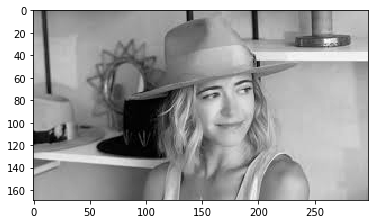

In [3]:
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(grey_img, cmap='gray')

Apply Gaussian kernel to remove noise

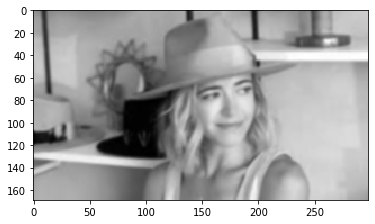

In [4]:
blurred_img = cv2.GaussianBlur(grey_img, (5, 5), 0)
plt.imshow(blurred_img, cmap='gray')

Apply sobel filter to obtain horizontal and vertical derivatives of image

In [5]:
sobelx = cv2.Sobel(blurred_img,cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(blurred_img,cv2.CV_64F, 0, 1, ksize=5)

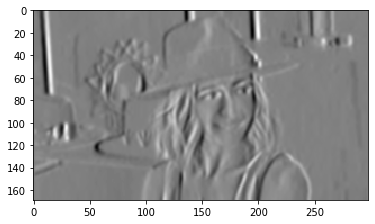

In [6]:
plt.imshow(sobelx, cmap='gray')

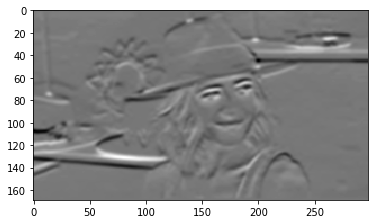

In [7]:
plt.imshow(sobely, cmap='gray')

Compute gradient(hyp) and angle(theta) matrices 

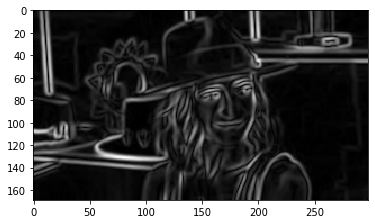

In [8]:
hyp = np.hypot(sobelx, sobely)
plt.imshow(hyp, cmap='gray')

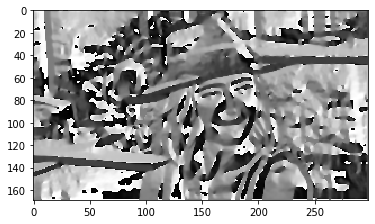

In [9]:
theta = np.arctan2(sobely, sobelx)
plt.imshow(theta, cmap='gray')

Perform non max suppression i.e. if pixel intensity is max in gradient direction then set it to max otherwise to zero

In [10]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N) , dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

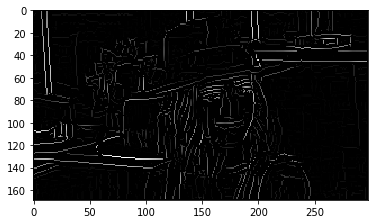

In [11]:
non_max_suppressed_img = non_max_suppression(hyp, theta)
plt.imshow(non_max_suppressed_img, cmap='gray')

Find weak and strong edges

In [12]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

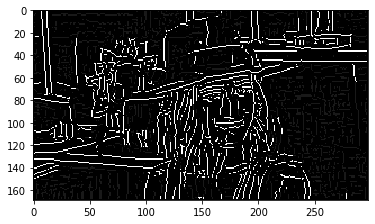

In [13]:
thresh_img, weak, strong = threshold(non_max_suppressed_img, 0.05, 0.09)
plt.imshow(thresh_img, cmap='gray')

If weak pixel is connected to strong, then it is strong, otherwise it remains weak and must be set to zero

In [14]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

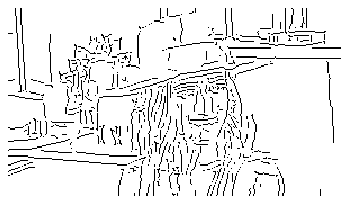

In [15]:
final_img = hysteresis(thresh_img, weak, strong)
plt.axis('off')
plt.imshow((255 - final_img), cmap='gray')

OpenCV canny edge detection

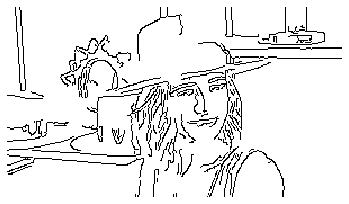

In [16]:
canny = cv2.Canny(grey_img, 100, 200)
plt.axis('off')
plt.imshow((255 - canny), cmap='gray')

Comparison

(-0.5, 297.5, 168.5, -0.5)

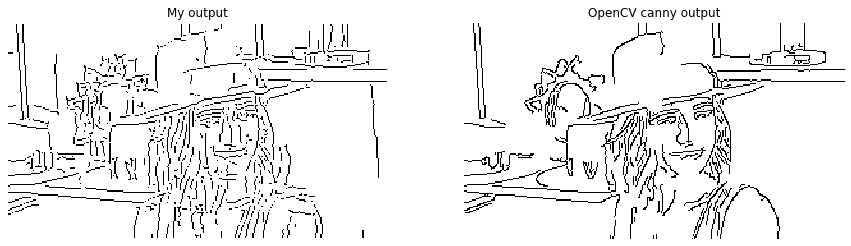

In [17]:
_, plots = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
plots[0].imshow((255 - final_img), cmap='gray')
plots[0].set_title('My output')
plots[0].axis('off')
plots[1].imshow((255 - canny), cmap='gray')
plots[1].set_title('OpenCV canny output')
plots[1].axis('off')

Future work: Fine tune algo to make the left image resemble the right image. Remove the unnecessary edges.